In [1]:
!pip install langchain langgraph langchain-community langchain-text-splitters langchain-groq langchain-huggingface langchain-chroma pymupdf arxiv sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [4]:
from typing_extensions import TypedDict, Literal, NotRequired
from typing import List, Dict, Any

class Query(TypedDict):
    original_query: str
    processed_query: str
    retrieval_type: Literal["semantic", "keyword", "hybrid", "bm25"]
    complexity_score: NotRequired[float]
    entities: NotRequired[List[str]]

class AgentState(TypedDict):
    question: str
    query: NotRequired[Query]
    documents: NotRequired[List[str]]
    answer: NotRequired[str]

In [5]:
from langchain_community.document_loaders import ArxivLoader
loader = ArxivLoader(query="retrieval augmented generation", doc_content_chars_max=50000)
docs = loader.load()[:5]

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
)

In [9]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)

In [10]:
def analyze_query_complexity(query: str) -> float:
    """Analyze query complexity based on length, entities, question words"""
    complexity = 0.0

    complexity += min(len(query) / 100, 1.0)

    question_words = ["what", "how", "why", "when", "where", "which", "explain", "compare"]
    complexity += sum(0.2 for word in question_words if word in query.lower())

    tech_terms = ["algorithm", "method", "approach", "technique", "model", "system"]
    complexity += sum(0.15 for term in tech_terms if term in query.lower())

    return min(complexity, 1.0)

In [11]:
import re
def extract_entities(query: str) -> List[str]:
    """Extract potential named entities"""
    entities = re.findall(r'\b[A-Z][a-z]+\b', query)
    return entities

In [12]:
def select_retrieval_strategy(query: str, complexity: float, entities: List[str]) -> str:
    """Select optimal retrieval strategy"""

    if any(word in query.lower() for word in ["specific", "exact", "definition"]):
        return "keyword"

    elif complexity > 0.7 or any(word in query.lower() for word in ["explain", "understand", "concept"]):
        return "semantic"

    elif len(entities) > 2 or "compare" in query.lower() or "versus" in query.lower():
        return "hybrid"

    else:
        return "bm25"

In [13]:
def analyze_query(state: AgentState) -> AgentState:
    """Analyze query and select retrieval strategy"""
    question = state["question"]

    complexity = analyze_query_complexity(question)
    entities = extract_entities(question)
    retrieval_type = select_retrieval_strategy(question, complexity, entities)

    query = Query(
        original_query=question,
        processed_query=question.lower().strip(),
        retrieval_type=retrieval_type,
        complexity_score=complexity,
        entities=entities
    )

    print(f"📊 Query Analysis:")
    print(f"   Complexity: {complexity:.2f}")
    print(f"   Entities: {entities}")
    print(f"   Selected Strategy: {retrieval_type}")

    return {**state, "query": query}

In [14]:
def retrieve_documents(state: AgentState) -> AgentState:
    """Retrieve documents using selected strategy"""
    query = state["query"]
    retrieval_type = query["retrieval_type"]
    search_query = query["processed_query"]

    if retrieval_type == "semantic":
        docs = vectorstore.similarity_search(search_query, k=3)

    elif retrieval_type == "keyword":
        docs = vectorstore.max_marginal_relevance_search(search_query, k=3)

    elif retrieval_type == "hybrid":
        semantic_docs = vectorstore.similarity_search(search_query, k=2)
        mmr_docs = vectorstore.max_marginal_relevance_search(search_query, k=2)
        docs = semantic_docs + mmr_docs

    else:  # bm25
        docs = vectorstore.similarity_search(search_query, k=4)

    doc_contents = [doc.page_content for doc in docs]

    print(f"🔍 Retrieved {len(doc_contents)} documents using {retrieval_type} strategy")

    return {**state, "documents": doc_contents}

In [15]:
def generate_answer(state: AgentState) -> AgentState:
    """Generate answer based on retrieved documents"""
    question = state["question"]
    documents = state.get("documents", [])

    context = "\n\n".join(documents)

    prompt = f"""Based on the following context, answer the question concisely and accurately.

Context:
{context}

Question: {question}

Answer:"""

    response = llm.invoke(prompt)
    answer = response.content

    print(f"✅ Generated answer ({len(answer)} characters)")

    return {**state, "answer": answer}

In [16]:
from langgraph.graph import StateGraph, START
builder = StateGraph(AgentState)
builder.add_node("analyze_query", analyze_query)
builder.add_node("retrieve_documents", retrieve_documents)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "analyze_query")
builder.add_edge("analyze_query", "retrieve_documents")
builder.add_edge("retrieve_documents", "generate_answer")

graph = builder.compile()

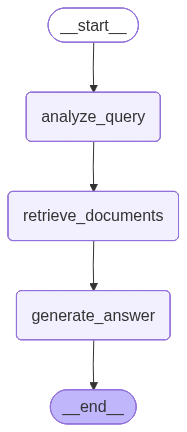

In [17]:
graph

In [18]:
test_queries = [
    "What is retrieval augmented generation?",
    "Define keyword search algorithm",
    "Compare semantic search versus BM25 retrieval methods",
    "How does RAG work?",
]

for query in test_queries:
    print(f"\n" + "="*60)
    print(f"🎯 Testing Query: {query}")
    print("="*60)

    initial_state = AgentState(question=query)
    result = graph.invoke(initial_state)

    print(f"\n📝 Final Answer:\n{result['answer'][:200]}...")


🎯 Testing Query: What is retrieval augmented generation?
📊 Query Analysis:
   Complexity: 0.59
   Entities: ['What']
   Selected Strategy: bm25
🔍 Retrieved 4 documents using bm25 strategy
✅ Generated answer (471 characters)

📝 Final Answer:
Retrieval‑augmented generation (RAG) is a technique that combines a retrieval model with a large language model: given a user query, a retriever first fetches relevant external documents (e.g., senten...

🎯 Testing Query: Define keyword search algorithm
📊 Query Analysis:
   Complexity: 0.46
   Entities: ['Define']
   Selected Strategy: bm25
🔍 Retrieved 4 documents using bm25 strategy
✅ Generated answer (828 characters)

📝 Final Answer:
A **keyword search algorithm** is a retrieval method that locates documents (or other items) containing one or more specified words (keywords). It typically works by:

1. **Indexing** the corpus with ...

🎯 Testing Query: Compare semantic search versus BM25 retrieval methods
📊 Query Analysis:
   Complexity: 0.88
   E